In [33]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 


In [34]:

## Load up helper objects

files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

# Helper Variable
stations = fv.st_avail(files, st_id_map = st_id_map)
st_dict = stations[['Lat', 'Lon']].to_dict('records')
#stations

In [35]:
## Choose a fire

In [36]:
snap = fv.prep_gdf(date = '20191031PM',handle_multi=True,only_lf=True,area_lim=5, index ='fireID',inplace=True)
snap.explore()

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:194: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:195: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


In [27]:
## Load up that fire 
fireID = '6638'
gdf = fv.load_large_fire(fireID)

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:253: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:254: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


In [28]:
## Get that fire lat lon

foi = gdf
foi = foi.rename(columns = {"lat": "Lat", "lon": "Lon"})
foi = foi.iloc[0] # First element
foi

n_pixels                                                     648
n_newpixels                                                   79
farea                                                  56.252596
fperim                                                 35.246344
flinelen                                                 3.15977
duration                                                     5.0
pixden                                                 11.519468
meanFRP                                                 1.033291
t                                            2019-09-15 00:00:00
geometry       POLYGON ((-116.80957899835748 42.5019188103601...
Lon                                                  -116.815372
Lat                                                    42.474321
Name: 0, dtype: object

In [29]:
## Look for closest station
st_cls = fv.closest(st_dict, foi)
st_cls["Lat"]

The closest station is 130.16298845055746 km away.


43.567

In [30]:
## Get station Data
st = fv.get_st(lat = st_cls["Lat"], lon = st_cls["Lon"], stations = stations)

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:87: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


In [31]:
## Merge with fire data

full_fr = fv.fr_st_merge(gdf, st, sub = True)


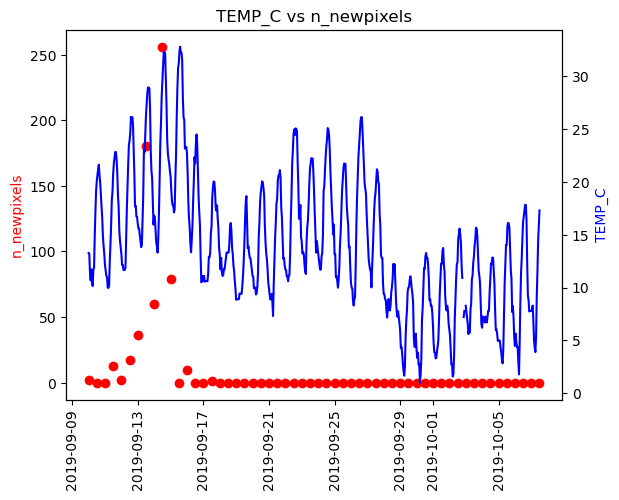

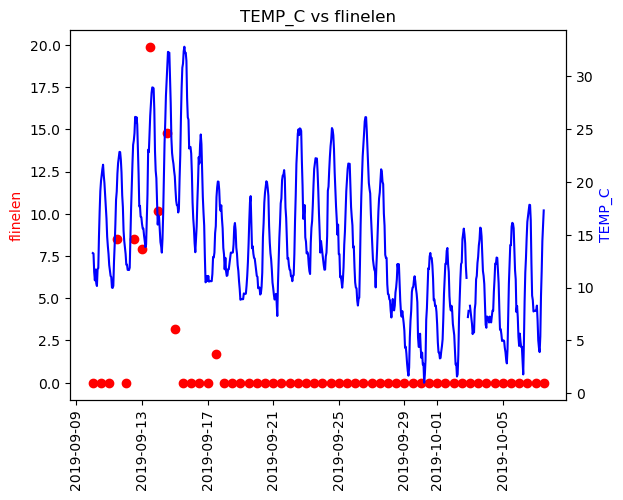

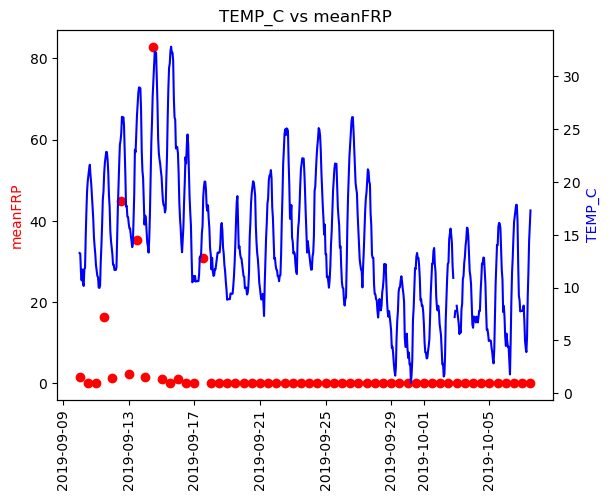

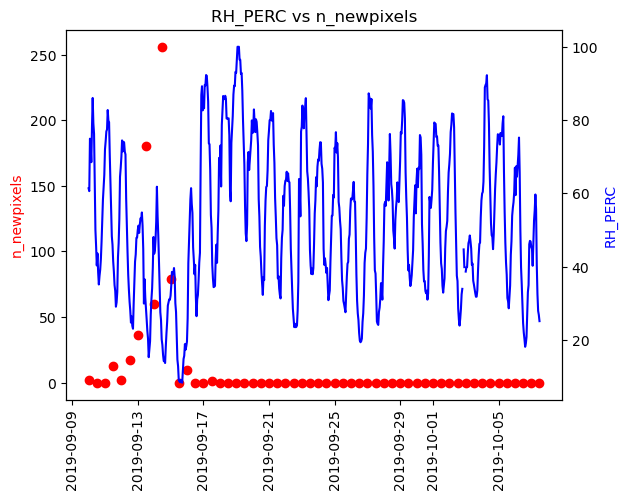

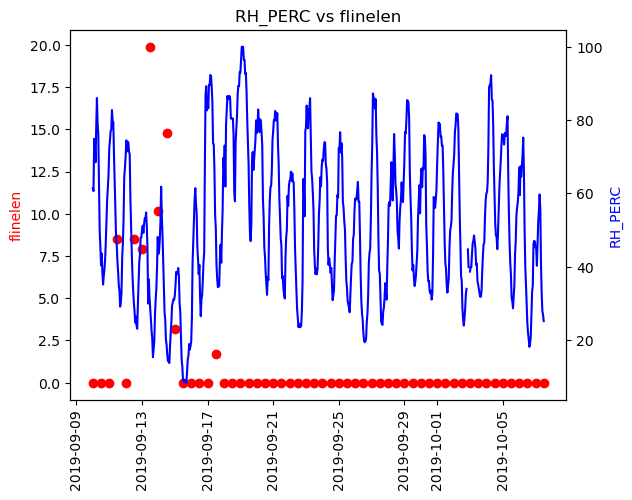

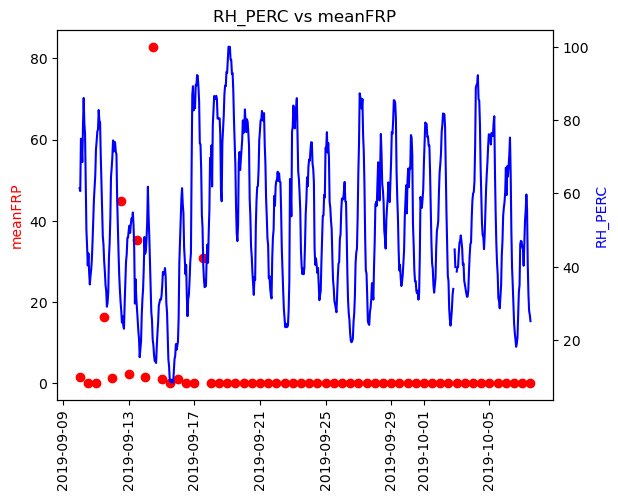

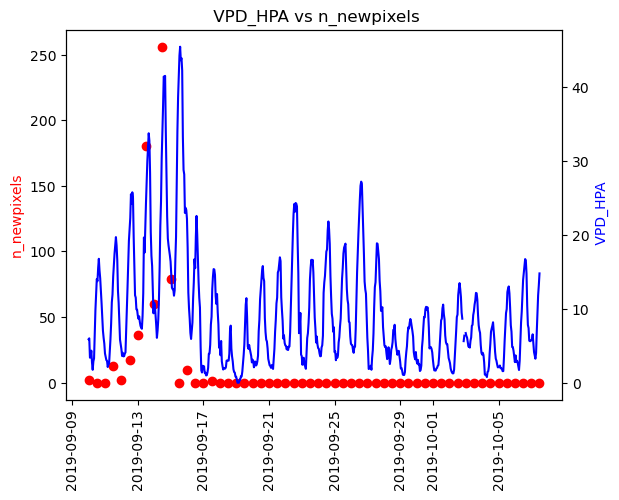

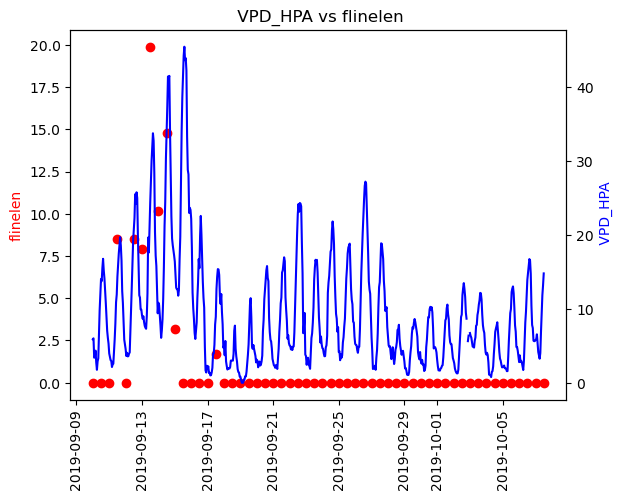

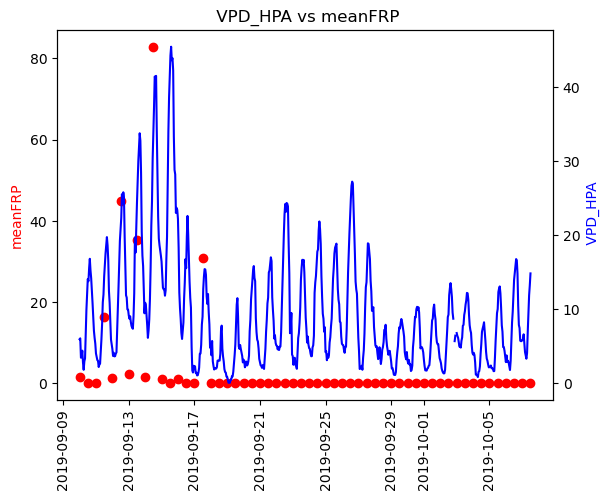

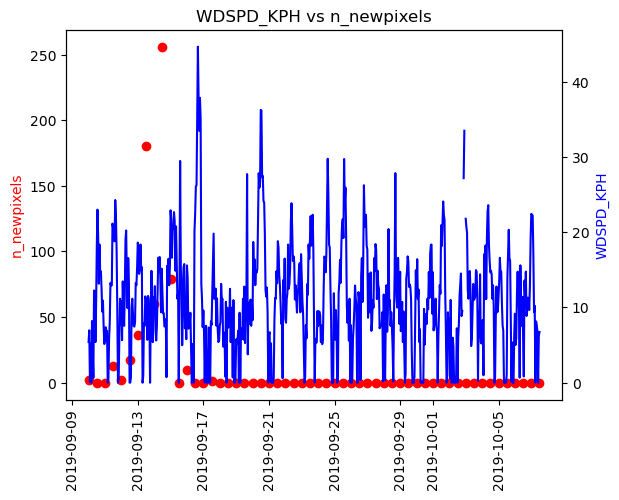

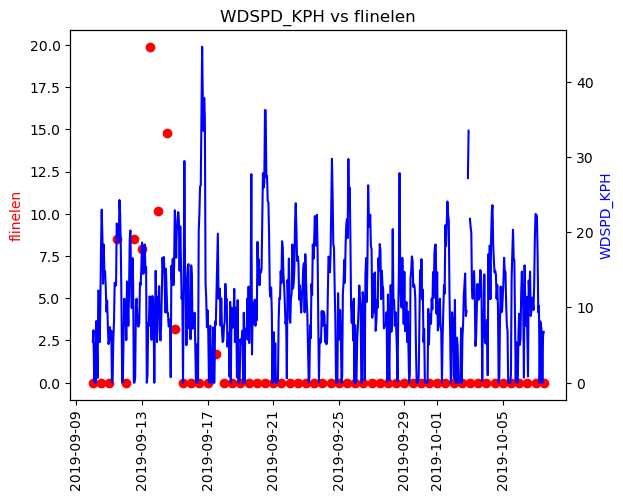

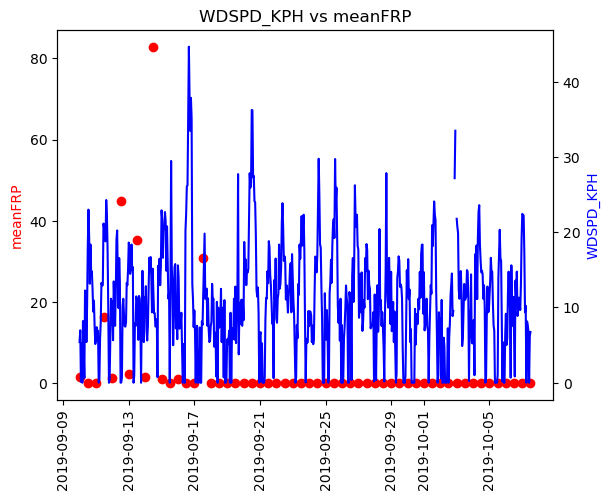

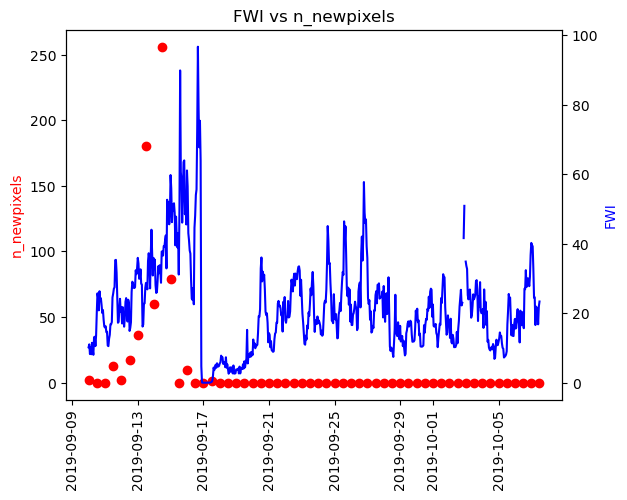

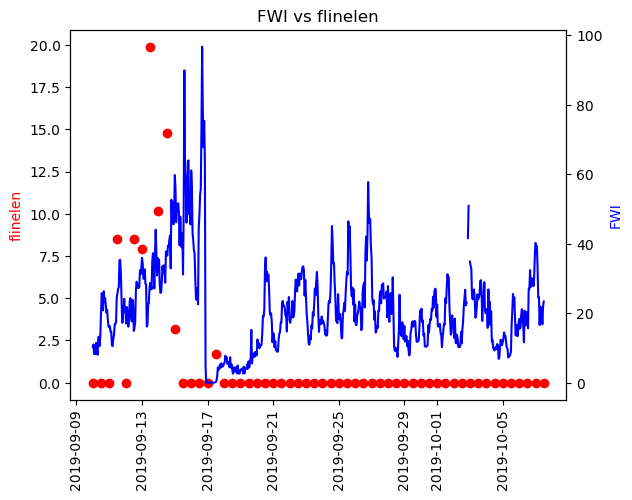

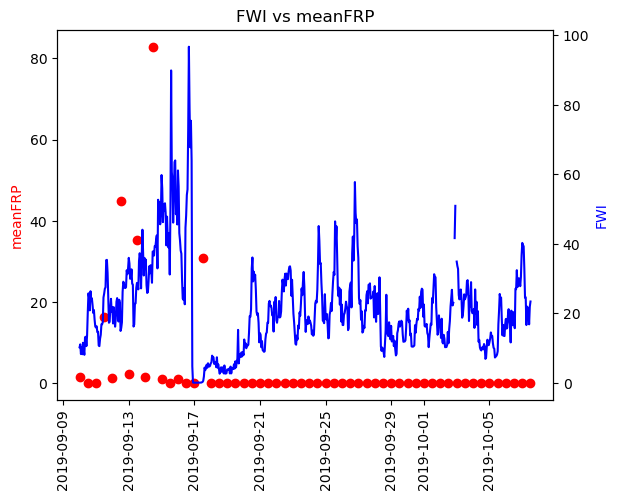

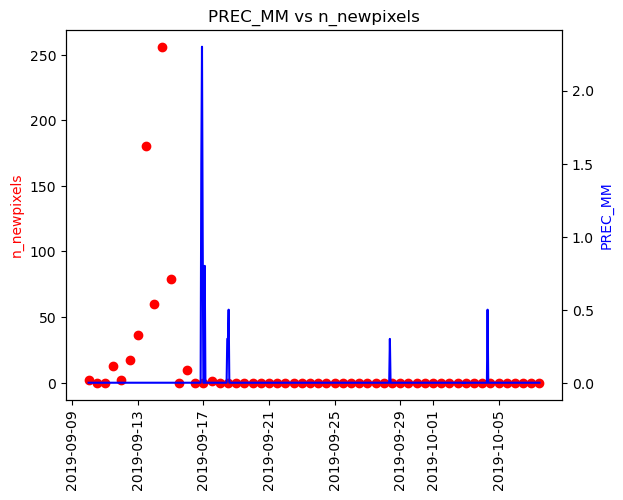

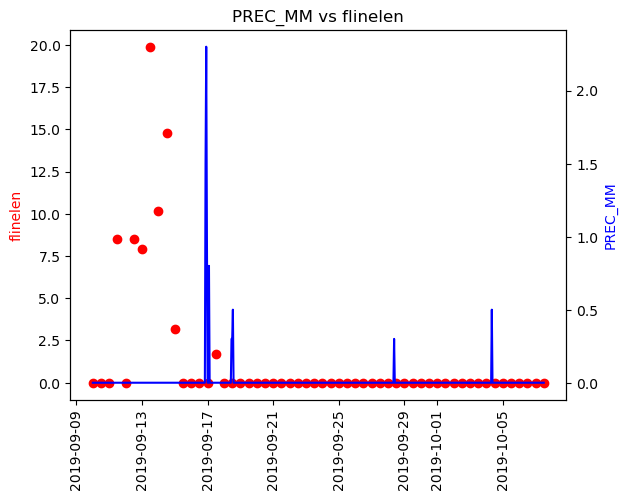

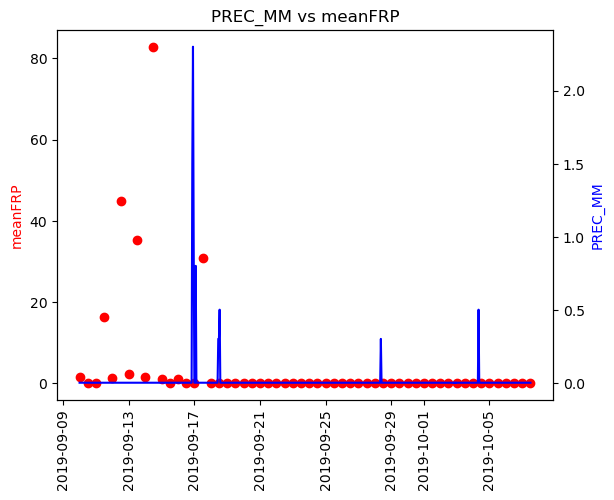

In [32]:
## Plot 

met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']
fire = [ 'n_newpixels', 'flinelen','meanFRP',]

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue")
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()